In [1]:
import pandas as pd 
from sklearn import preprocessing 
data = pd.read_csv("iris.csv") 
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
device = torch.device('cpu')
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(data)

            1         2         3         4         5         6         7  \
0    0.000000  1.172291  0.842784  1.100000  0.259270  1.034977  0.659123   
1    1.172291  0.000000  0.521625  0.432551  1.381856  2.173923  0.995320   
2    0.842784  0.521625  0.000000  0.282943  0.988261  1.847707  0.495533   
3    1.100000  0.432551  0.282943  0.000000  1.245986  2.093760  0.702962   
4    0.259270  1.381856  0.988261  1.245986  0.000000  0.897108  0.679044   
5    1.034977  2.173923  1.847707  2.093760  0.897108  0.000000  1.515053   
6    0.659123  0.995320  0.495533  0.702962  0.679044  1.515053  0.000000   
7    0.265386  0.927356  0.595516  0.840878  0.462340  1.277088  0.503747   
8    1.615409  0.645935  0.779871  0.521625  1.761886  2.611481  1.179609   
9    0.959662  0.270292  0.375526  0.385312  1.162298  1.975125  0.822827   
10   0.587377  1.716692  1.429466  1.681756  0.537761  0.540584  1.194788   
11   0.443539  0.932532  0.503997  0.731628  0.530773  1.383114  0.297292   

In [2]:
# Normalize the data attributes for the Iris dataset.
from sklearn.datasets import load_iris
from sklearn import preprocessing
# load the iris dataset
iris = load_iris()
print(iris.data.shape)
# separate the data from the target attributes
X = iris.data
print(X)
y = iris.target
# normalize the data attributes
#normalized_X = preprocessing.normalize(X)
normalized_X = preprocessing.normalize(X)

(150, 4)
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6

In [3]:
from scipy.spatial.distance import pdist,squareform
mat = squareform(pdist(normalized_X, metric='euclidean'))
A_hat = numpy.reciprocal(mat, where= mat > 0.0, out = np.zeros_like(mat))

In [4]:
class CDCGS(nn.Module):
  def __init__(self, A_hat, num_feat, num_hidden):
    super(CDCGS, self).__init__()
    self.num_feat = num_feat
    self.num_hidden = num_hidden
    self.A_hat = A_hat
    self.W_0 = nn.Parameter(torch.ones(num_feat, 3))
    print(self.W_0.size())
    self.W_1 = nn.Parameter(torch.ones(num_feat, num_hidden))
    I = F.one_hot(torch.tensor(random.sample(range(0, num_feat), num_feat)), num_classes=num_feat)
    self.I = torch.tensor(I,dtype=torch.float)

  def forward(self, X, A_hat,temp):
    global featureSelector
    global weight_feature
    featureSelector = self.W_0
    results = torch.zeros(self.W_0.size())
    x = 100
    for i in range(x):
        results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
    weight_feature = results/x

    #H = torch.mm(X_tensor,self.W_1.T)
    H = torch.mm(torch.mm(weight_feature.T,X_tensor),weight_feature)
    H = torch.div(H, H.sum(axis=0))
    m = nn.Softmax(dim=0)
    return m(H)

num_hidden = len(A_hat[0])

model = CDCGS(A_hat, len(A_hat), num_hidden).to(device)

def lossFn(output,exp): 
    return torch.sum((torch.diag(-torch.log(output))))

optimizer = optim.Adam(model.parameters(),lr=5e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)

X_tensor = torch.Tensor(A_hat).to(device)

loss_hist = []
acc_hist = []
temp = 2
logits=[]
for epoch in range(200):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 0.75
    elif(epoch == 150):
        temp = 0.1
    output = model(X_tensor, 0,temp)
    #print(output)
    loss = lossFn(output,torch.diag(torch.ones(output.size()[0])))/3
    loss_hist.append(loss.item())
    print('loss',epoch,loss)
    loss.backward()
    optimizer.step()



torch.Size([150, 3])
loss 0 tensor(1.0986, grad_fn=<DivBackward0>)
loss 1 tensor(1.0986, grad_fn=<DivBackward0>)


/opt/anaconda/envs/Deepak/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


loss 2 tensor(1.0984, grad_fn=<DivBackward0>)
loss 3 tensor(1.0981, grad_fn=<DivBackward0>)
loss 4 tensor(1.0976, grad_fn=<DivBackward0>)
loss 5 tensor(1.0968, grad_fn=<DivBackward0>)
loss 6 tensor(1.0958, grad_fn=<DivBackward0>)
loss 7 tensor(1.0939, grad_fn=<DivBackward0>)
loss 8 tensor(1.0922, grad_fn=<DivBackward0>)
loss 9 tensor(1.0898, grad_fn=<DivBackward0>)
loss 10 tensor(1.0876, grad_fn=<DivBackward0>)
loss 11 tensor(1.0834, grad_fn=<DivBackward0>)
loss 12 tensor(1.0794, grad_fn=<DivBackward0>)
loss 13 tensor(1.0753, grad_fn=<DivBackward0>)
loss 14 tensor(1.0704, grad_fn=<DivBackward0>)
loss 15 tensor(1.0653, grad_fn=<DivBackward0>)
loss 16 tensor(1.0585, grad_fn=<DivBackward0>)
loss 17 tensor(1.0516, grad_fn=<DivBackward0>)
loss 18 tensor(1.0449, grad_fn=<DivBackward0>)
loss 19 tensor(1.0372, grad_fn=<DivBackward0>)
loss 20 tensor(1.0295, grad_fn=<DivBackward0>)
loss 21 tensor(1.0216, grad_fn=<DivBackward0>)
loss 22 tensor(1.0143, grad_fn=<DivBackward0>)
loss 23 tensor(1.0059

loss 176 tensor(0.7693, grad_fn=<DivBackward0>)
loss 177 tensor(0.7692, grad_fn=<DivBackward0>)
loss 178 tensor(0.7692, grad_fn=<DivBackward0>)
loss 179 tensor(0.7690, grad_fn=<DivBackward0>)
loss 180 tensor(0.7694, grad_fn=<DivBackward0>)
loss 181 tensor(0.7693, grad_fn=<DivBackward0>)
loss 182 tensor(0.7692, grad_fn=<DivBackward0>)
loss 183 tensor(0.7692, grad_fn=<DivBackward0>)
loss 184 tensor(0.7691, grad_fn=<DivBackward0>)
loss 185 tensor(0.7693, grad_fn=<DivBackward0>)
loss 186 tensor(0.7690, grad_fn=<DivBackward0>)
loss 187 tensor(0.7692, grad_fn=<DivBackward0>)
loss 188 tensor(0.7693, grad_fn=<DivBackward0>)
loss 189 tensor(0.7690, grad_fn=<DivBackward0>)
loss 190 tensor(0.7690, grad_fn=<DivBackward0>)
loss 191 tensor(0.7692, grad_fn=<DivBackward0>)
loss 192 tensor(0.7691, grad_fn=<DivBackward0>)
loss 193 tensor(0.7693, grad_fn=<DivBackward0>)
loss 194 tensor(0.7690, grad_fn=<DivBackward0>)
loss 195 tensor(0.7694, grad_fn=<DivBackward0>)
loss 196 tensor(0.7692, grad_fn=<DivBack

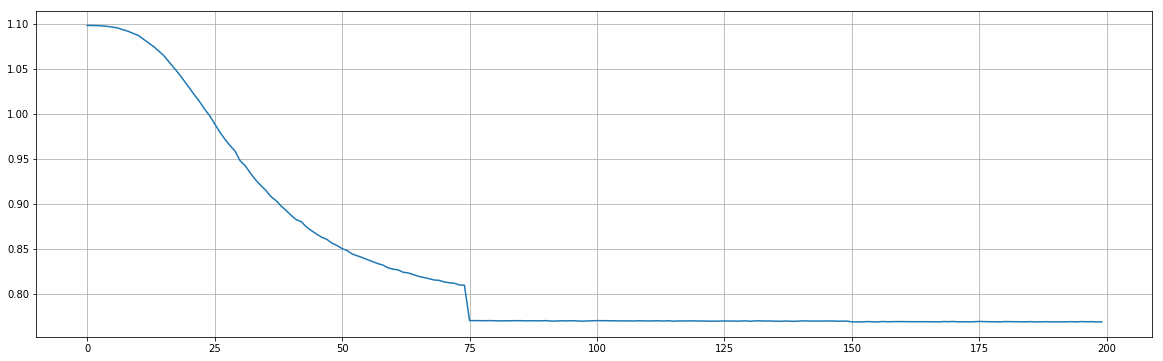

In [5]:
plt.figure(figsize=(20, 6))
plt.plot(loss_hist)
plt.grid(True)
plt.show()

In [6]:
gumbel_matrix = weight_feature.detach().max(dim=1)[1]
print(gumbel_matrix)
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
labels_true = y
print(y)

labels_pred = gumbel_matrix.data.numpy()
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))
clusters = np.unique(labels_pred)

print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
adjusted_rand_score 0.8859501978730681
normalized_mutual_info_score 0.8862311759668319
homogeneity_score 0.8842904647916655
completeness_score 0.8881804242552008
v_measure_score 0.8862311

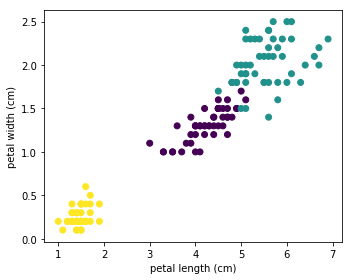

In [7]:
# Load the data
from sklearn.datasets import load_iris
iris = load_iris()

from matplotlib import pyplot as plt
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# The indices of the features that we are plotting
x_index = 2
y_index = 3

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.figure(figsize=(5, 4))
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c= labels_true)
#plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

plt.tight_layout()
plt.show()

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


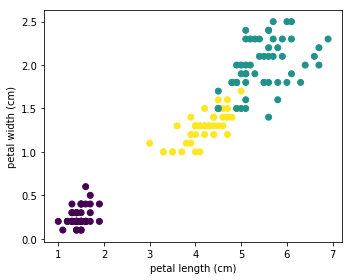

In [8]:
import itertools

# labels_true = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
#         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
#         2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
#         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#         0, 0, 0, 0, 0, 0]
#labels_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
labels_true = gumbel_matrix
# Load the data
print(iris.feature_names)
from sklearn.datasets import load_iris
iris = load_iris()

from matplotlib import pyplot as plt

# The indices of the features that we are plotting
x_index = 2
y_index = 3

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.figure(figsize=(5, 4))
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=labels_true)
#plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

plt.tight_layout()
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 2
 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


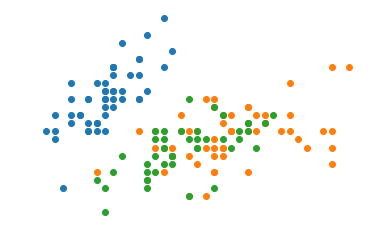

adjusted_rand_score 0.8859501978730681
normalized_mutual_info_score 0.8862311759668319
homogeneity_score 0.8842904647916655
completeness_score 0.8881804242552008
v_measure_score 0.8862311759668319
------------------
GUMBEL SOFTMAX
------------------
0.8859501978730681
0.8862311759668319
0.8842904647916655
0.8881804242552008
0.8862311759668319


In [21]:
import matplotlib.pyplot as pyplot

gumbel_matrix = weight_feature.detach().max(dim=1)[1]
print(gumbel_matrix.numpy())
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#labels_true = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
labels_true = y
#print(y)
labels_pred = gumbel_matrix.data.numpy()
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from sklearn import metrics
clusters = np.unique(labels_pred)

from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()

print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))
print('------------------')
print('GUMBEL SOFTMAX')
print('------------------')
print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


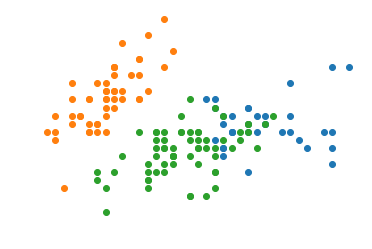

adjusted_rand_score 0.745503868180448
normalized_mutual_info_score 0.7979885217013319
homogeneity_score 0.7869234996582516
completeness_score 0.8093691546872487
v_measure_score 0.797988521701332
------------------
SpectralClustering
------------------
0.745503868180448
0.7979885217013319
0.7869234996582516
0.8093691546872487
0.797988521701332


In [22]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation,SpectralClustering, AgglomerativeClustering, OPTICS, Birch, DBSCAN, KMeans, MiniBatchKMeans, MeanShift
Num_class = 3
from numpy import where
from sklearn.datasets import make_classification, make_moons, make_gaussian_quantiles
from matplotlib import pyplot

model = SpectralClustering(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.fit_predict(X)
# retrieve unique clusters
print(labels_pred)
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))
print('------------------')
print('SpectralClustering')
print('------------------')
print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

------------------
Birch
------------------


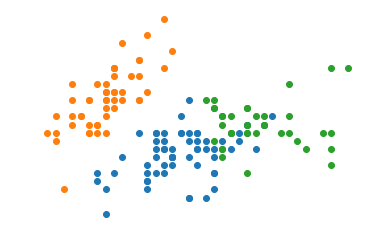

adjusted_rand_score 0.7311985567707745
normalized_mutual_info_score 0.770083661648787
homogeneity_score 0.7608008469718723
completeness_score 0.7795958005591144
v_measure_score 0.7700836616487869
0.7311985567707745
0.770083661648787
0.7608008469718723
0.7795958005591144
0.7700836616487869


In [23]:
print('------------------')
print('Birch')
print('------------------')
model = Birch(threshold=0.01, n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()

print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))

print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

------------------
AgglomerativeClustering
------------------


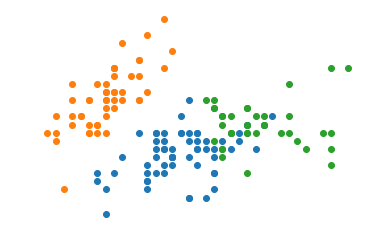

adjusted_rand_score 0.7311985567707745
normalized_mutual_info_score 0.770083661648787
homogeneity_score 0.7608008469718723
completeness_score 0.7795958005591144
v_measure_score 0.7700836616487869
0.7311985567707745
0.770083661648787
0.7608008469718723
0.7795958005591144
0.7700836616487869


In [24]:
print('------------------')
print('AgglomerativeClustering')
print('------------------')
model = AgglomerativeClustering(n_clusters=Num_class)
# fit model and predict clusters
labels_pred = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))


print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

------------------
KMeans
------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


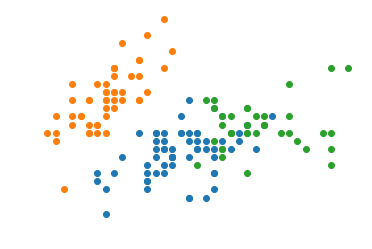

adjusted_rand_score 0.7302382722834697
normalized_mutual_info_score 0.7581756800057785
homogeneity_score 0.7514854021988339
completeness_score 0.7649861514489816
v_measure_score 0.7581756800057786
0.7302382722834697
0.7581756800057785
0.7514854021988339
0.7649861514489816
0.7581756800057786


In [25]:

print('------------------')
print('KMeans')
print('------------------')
model = KMeans(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
print(labels_pred)
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))


print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

------------------
MiniBatchKMeans
------------------


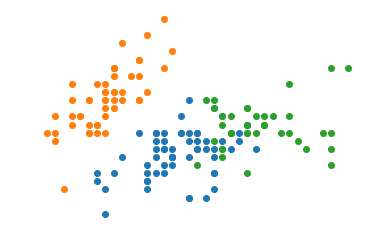

adjusted_rand_score 0.7163421126838475
normalized_mutual_info_score 0.7419116631817836
homogeneity_score 0.7364192881252849
completeness_score 0.7474865805095324
v_measure_score 0.7419116631817836
0.7163421126838475
0.7419116631817836
0.7364192881252849
0.7474865805095324
0.7419116631817836


In [26]:
print('------------------')
print('MiniBatchKMeans')
print('------------------')
model = MiniBatchKMeans(n_clusters=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))


print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

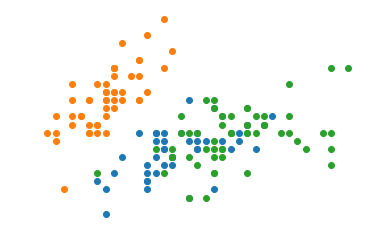

adjusted_rand_score 0.9038742317748124
normalized_mutual_info_score 0.8996935451597475
homogeneity_score 0.8983263672602775
completeness_score 0.9010648908640206
v_measure_score 0.8996935451597475
0.9038742317748124
0.8996935451597475
0.8983263672602775
0.9010648908640206
0.8996935451597475


In [27]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define dataset
# define the model
model = GaussianMixture(n_components=Num_class)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))


print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))

AffinityPropagation


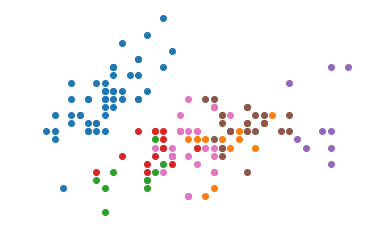

adjusted_rand_score 0.6053954267393473
normalized_mutual_info_score 0.6966464907504164
homogeneity_score 0.9175831936564605
completeness_score 0.5614580068054518
v_measure_score 0.6966464907504164
0.6053954267393473
0.6966464907504164
0.9175831936564605
0.5614580068054518
0.6966464907504164


In [28]:
print('AffinityPropagation')

model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X)
# assign a cluster to each example
labels_pred = model.predict(X)
# retrieve unique clusters
clusters = unique(labels_pred)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(labels_pred == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.axis('off')

pyplot.show()
print('adjusted_rand_score',adjusted_rand_score(labels_true, labels_pred))
print('normalized_mutual_info_score',normalized_mutual_info_score(labels_true, labels_pred))
print('homogeneity_score',metrics.homogeneity_score(labels_true, labels_pred))
print('completeness_score',metrics.completeness_score(labels_true, labels_pred))
print('v_measure_score',metrics.v_measure_score(labels_true, labels_pred))


print(adjusted_rand_score(labels_true, labels_pred))
print(normalized_mutual_info_score(labels_true, labels_pred))
print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))